
**Remark: please answer each question in its own cell.**

On Quercus, submit both a PDF printout of your assignment (for easier grading) and the ipynb file.

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [501]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.


In [502]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

zsh:1: command not found: gdown


In [503]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [504]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

"fit_on_texts" method creates the vocabulary index based on word frequency. It create dictionary that maps word to index, thus every word in the dictionary gets unique integer value while index 0 is reserved for padding. Lower integer value indicate the word are used frequently.

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

"texts_to_sequences" transforms every word in the sentence to sequence of integer. the value of integer for each word is based on the dictionary created from fit_on_texts method.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

"pad_sequences" method takes sequence of integer created using texts_to_sequence, and transform them into 2d numpy array with shape (number of sample in dict*length of the longest sequence in the list{maxlen}). Any sequence in the sample that has shorter length then maxlen, is padded with "value"(this could be given as parameter of the "pad_sequences" method).

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [505]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [506]:
print(messages_train.shape)
print(messages_train)

(40000, 200)
[[ 634   12  239 ...  156  206  352]
 [  10   37   97 ...   89  103    9]
 [   0    0    0 ...    2  712   64]
 ...
 [   0    0    0 ... 1611    2  601]
 [   0    0    0 ...  244  103  125]
 [   0    0    0 ...  481   70   72]]


There are 50000 number of sample comments in the IMDB dataset, and 80% of 50000 which is 40000 should be the number of the rows for training set, which is true. Also for column we have set limit to 200, thus the shape of the training set match what I expected the dataset to look like. Moreover, individual element are all comprised on integer value with 0s for padding. For these reason we could observe that the training set has form what we intended them to be.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [507]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

In [508]:

embed = Embed(200,30)
w = embed(messages_train[0]).shape
print(w)

(200, 30)


**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

To use Embed object you need to first initialize and create instance of class Embed. This could be done something like embed = Embed(size_initialization, latent_initialization). and size and latent are the type of weight initialization is defined when we first create instance of Embed. Everytime we try to create word embedding for specific sentence we call the object created by embed(sentence). __call__ function is used when object is directly called, and it returns the self.w.value[x] in our case. 

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

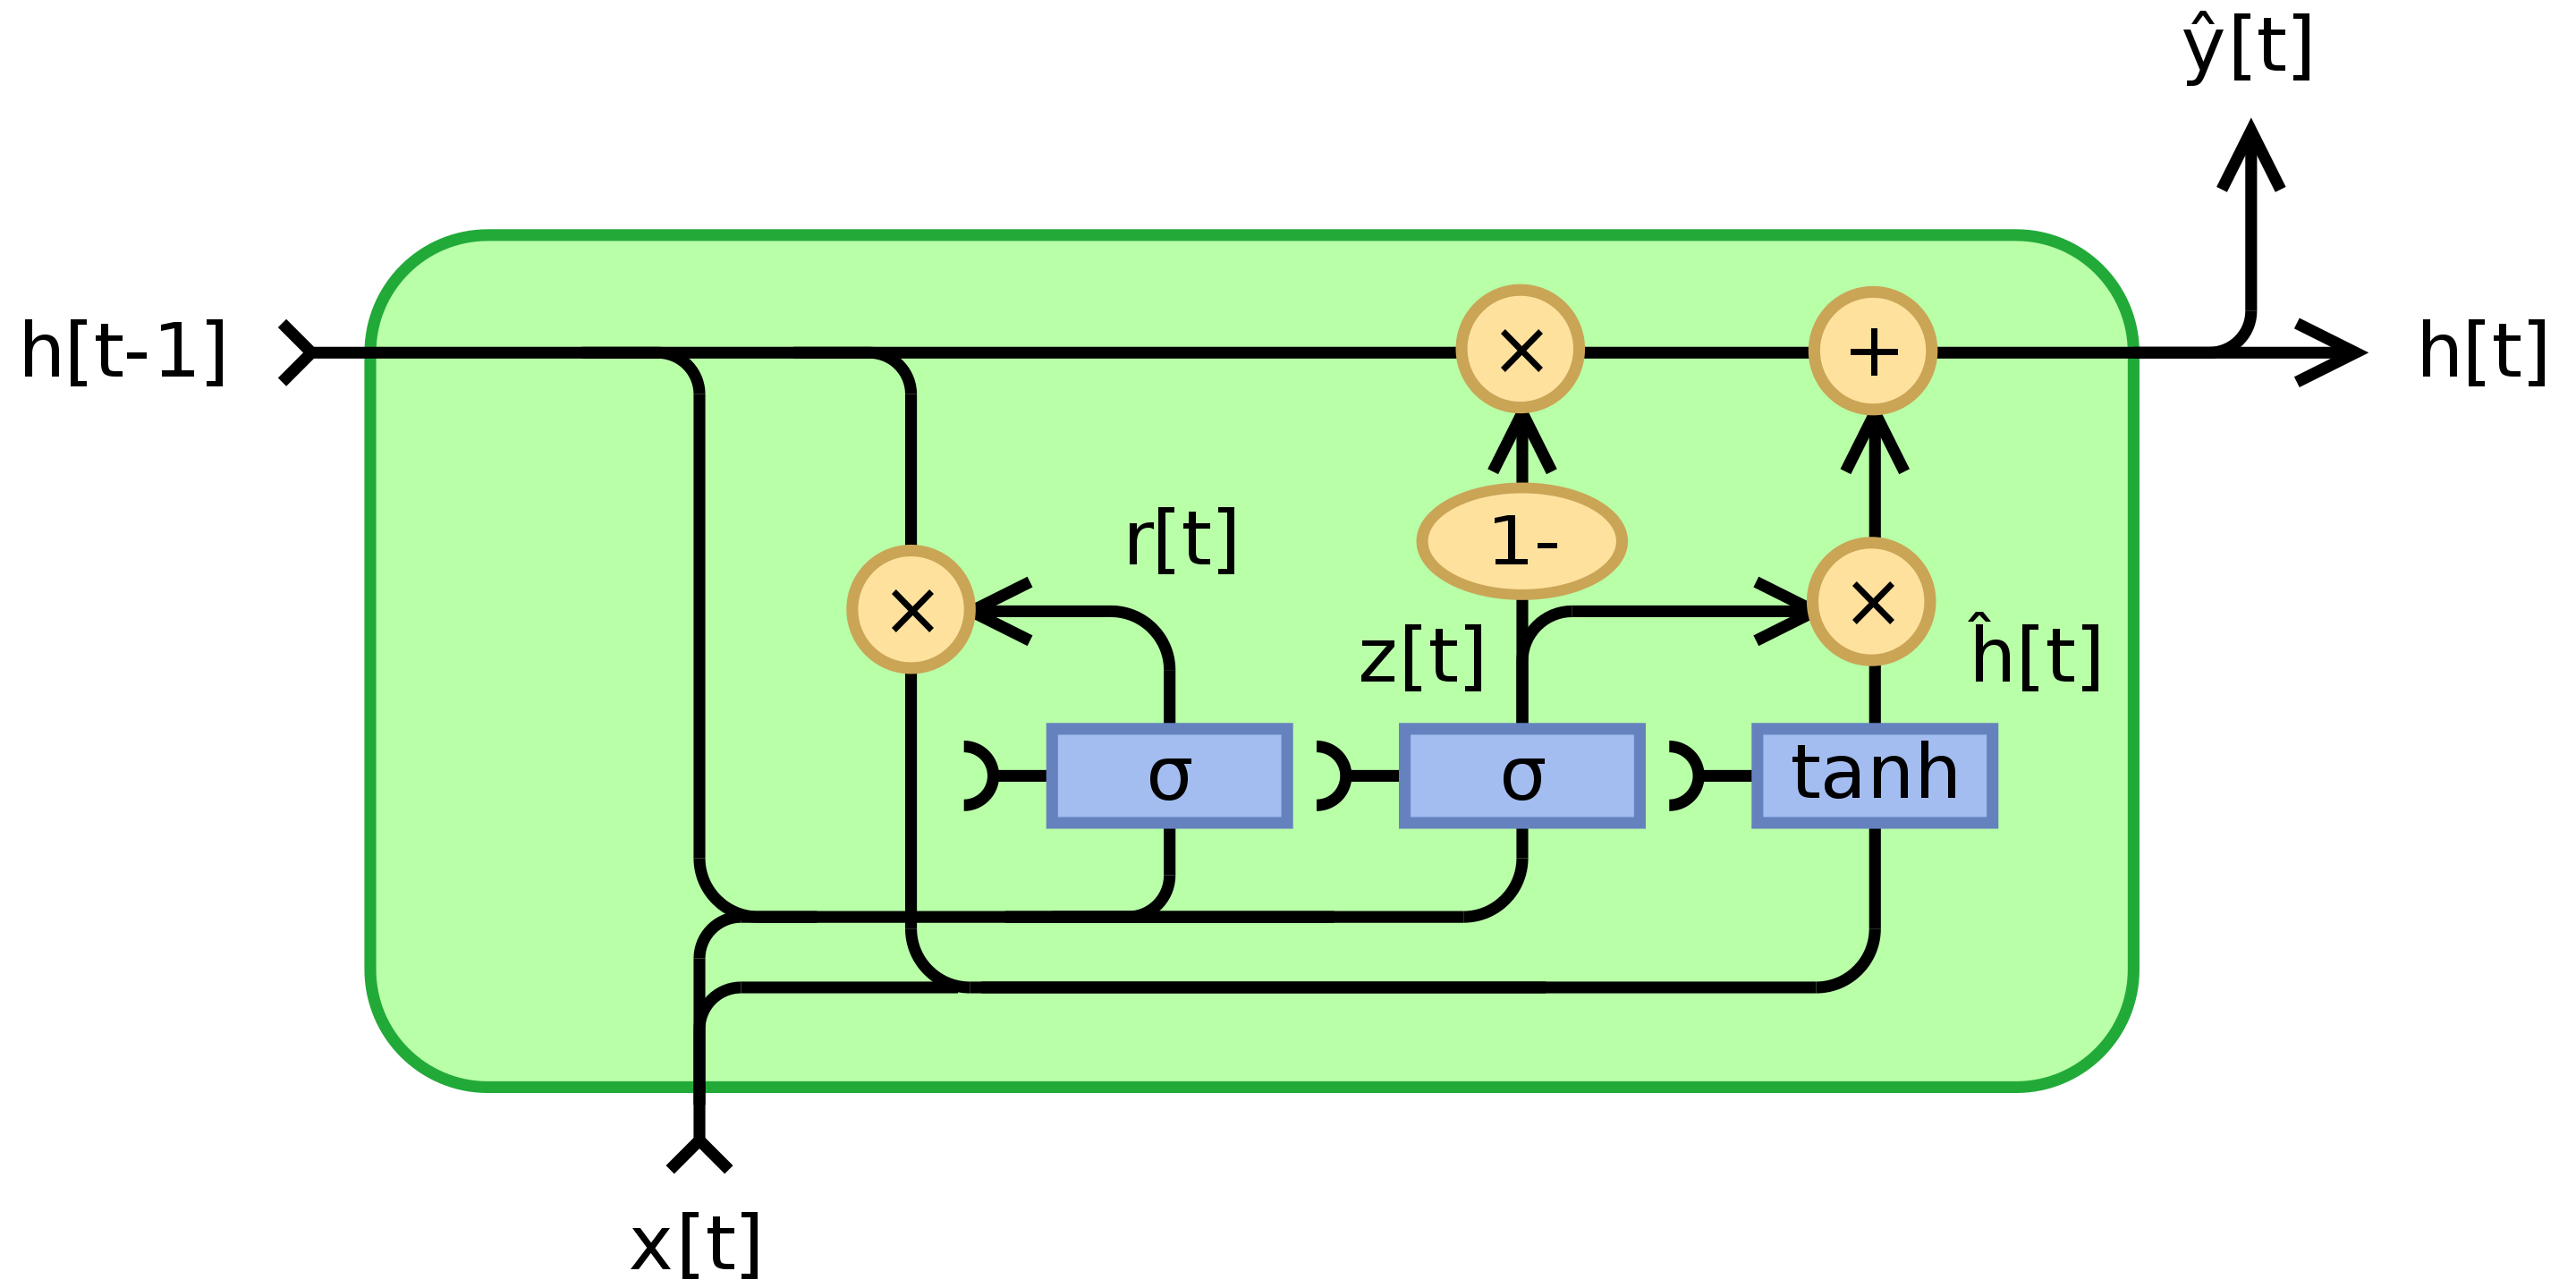

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [509]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.dot(x, self.update_w.value) + jn.dot(state, self.update_u.value) + self.update_b.value)

            # fill this in
            reset_gate = objax.functional.sigmoid(jn.dot(x, self.reset_w.value) + jn.dot(state, self.reset_u.value) + self.reset_b.value)
            
            # fill this in
            output_gate = jn.multiply((1- update_gate),state) + \
                          jn.multiply(update_gate, 
                                      objax.functional.tanh(jn.dot(x, self.output_w.value) + 
                                                            jn.dot(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value)
                                     )
            
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

lax.scan implements looping with carry over between loops. Following is the example of lax.scan

In [510]:
def cumulative_sum(res, el):
    res = res + el
    return res, res
a = np.array([1, 2, 3, 5, 7, 11, 13, 17])
result_init = 0
final, result = lax.scan(cumulative_sum, result_init, a)
print(final)
print(result)

59
[ 1  3  6 11 18 29 42 59]


In this case the initial_result has passed into cumulative_sum as res on the first call, and the cumulated carry got added on to perform addition with next element in array of a. Thereby resulting one array with cumulative result, and final carry value.

This is useful since we have eliminated the for-loop that have carry over by using `lax.scan`

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [511]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    Embed(max_len, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [512]:
gru_rnn(messages_train, initial_state=jn.zeros((messages_train.shape[0], num_hidden_units_GRU)))

DeviceArray([[ 0.02096302,  0.02872126],
             [ 0.02520918, -0.00121834],
             [ 0.03204282,  0.04055223],
             ...,
             [ 0.03818955,  0.04856836],
             [ 0.03382886,  0.01730616],
             [ 0.02341829,  0.02044159]], dtype=float32)

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [513]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

![diagram](q9_diagram.png)

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [530]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [531]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [532]:

def accuracy(data_loader, batch_size):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = batch_size
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [533]:
learning_rate = 1e-3 # learning rate
num_epochs = 30 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [534]:
def train1(EPOCHS=num_epochs, BATCH=batch_size, LEARNING_RATE=learning_rate):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []
    for epoch in range(EPOCHS):
      avg_train_loss = 0 
      avg_val_loss =  0
      train_acc = 0      
      val_acc = 0      

      train_indices = np.arange(len(training_data[0])) 
      np.random.shuffle(train_indices)
      for it in range(0, training_data[0].shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(training_data[0][batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
      train_acc_epoch.append(train_acc/training_data[0].shape[0])
      avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

      val_indices = np.arange(len(validation_data[0])) 
      np.random.shuffle(val_indices)    
      for it in range(0, validation_data[0].shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
          val_prediction = eval_op(validation_data[0][batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
      val_acc_epoch.append(val_acc/validation_data[0].shape[0])
      avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/validation_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()
    return (train_acc_epoch, val_acc_epoch)

Epoch 0001  Training Loss 171.40 Validation Loss 170.99 Training Accuracy 56.56 Validation Accuracy 54.86
Epoch 0002  Training Loss 168.81 Validation Loss 163.31 Training Accuracy 58.36 Validation Accuracy 61.76
Epoch 0003  Training Loss 166.32 Validation Loss 162.31 Training Accuracy 60.64 Validation Accuracy 62.36
Epoch 0004  Training Loss 163.63 Validation Loss 157.95 Training Accuracy 62.82 Validation Accuracy 65.04
Epoch 0005  Training Loss 160.54 Validation Loss 148.88 Training Accuracy 64.60 Validation Accuracy 68.96
Epoch 0006  Training Loss 155.89 Validation Loss 146.08 Training Accuracy 66.61 Validation Accuracy 69.92
Epoch 0007  Training Loss 152.44 Validation Loss 154.69 Training Accuracy 68.39 Validation Accuracy 66.12
Epoch 0008  Training Loss 146.18 Validation Loss 136.13 Training Accuracy 69.94 Validation Accuracy 73.68
Epoch 0009  Training Loss 142.19 Validation Loss 131.70 Training Accuracy 71.28 Validation Accuracy 74.04
Epoch 0010  Training Loss 139.50 Validation Lo

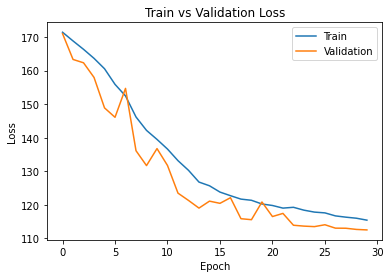

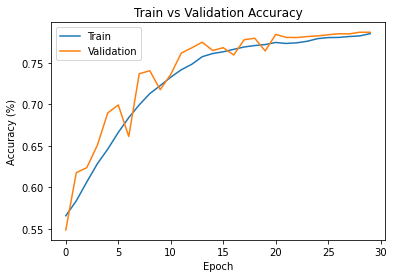

In [535]:
train_acc, val_acc= train1()

In [536]:
test_acc = accuracy(test_data, batch_size=batch_size)
print("test accuracy is ",test_acc)

test accuracy is  0.782


**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

for diagrams look at question 11.

In [537]:
print("Generalization gab between test and training: ", train_acc[-1]-test_acc)

Generalization gab between test and training:  0.003099978


# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [538]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    Embed(max_len, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [539]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [540]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [541]:
learning_rate = 1e-3
num_epochs = 30
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [542]:
def train2(EPOCHS=num_epochs, BATCH=batch_size, LEARNING_RATE=learning_rate):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []
    for epoch in range(EPOCHS):
      avg_train_loss = 0
      avg_val_loss =  0  
      train_acc = 0      
      val_acc = 0       

      train_indices = np.arange(len(training_data[0])) 
      np.random.shuffle(train_indices)
      for it in range(0, training_data[0].shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(training_data[0][batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
      train_acc_epoch.append(train_acc/training_data[0].shape[0])
      avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

      val_indices = np.arange(len(validation_data[0])) 
      np.random.shuffle(val_indices)    
      for it in range(0, validation_data[0].shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
          val_prediction = eval_op(validation_data[0][batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
      val_acc_epoch.append(val_acc/validation_data[0].shape[0])
      avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/validation_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()
    return (train_acc_epoch, val_acc_epoch)

Epoch 0001  Training Loss 153.40 Validation Loss 126.18 Training Accuracy 65.07 Validation Accuracy 75.74
Epoch 0002  Training Loss 129.42 Validation Loss 124.69 Training Accuracy 74.75 Validation Accuracy 75.62
Epoch 0003  Training Loss 128.25 Validation Loss 132.52 Training Accuracy 75.14 Validation Accuracy 72.88
Epoch 0004  Training Loss 128.30 Validation Loss 123.59 Training Accuracy 74.79 Validation Accuracy 75.88
Epoch 0005  Training Loss 127.50 Validation Loss 122.13 Training Accuracy 75.05 Validation Accuracy 76.50
Epoch 0006  Training Loss 128.44 Validation Loss 125.80 Training Accuracy 74.62 Validation Accuracy 76.06
Epoch 0007  Training Loss 126.29 Validation Loss 121.36 Training Accuracy 75.09 Validation Accuracy 76.86
Epoch 0008  Training Loss 123.04 Validation Loss 119.69 Training Accuracy 76.22 Validation Accuracy 76.94
Epoch 0009  Training Loss 121.00 Validation Loss 119.72 Training Accuracy 76.63 Validation Accuracy 76.78
Epoch 0010  Training Loss 120.31 Validation Lo

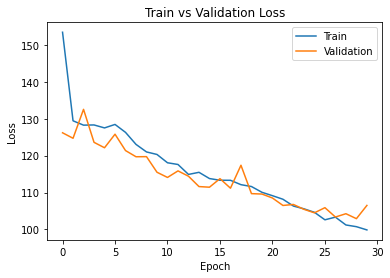

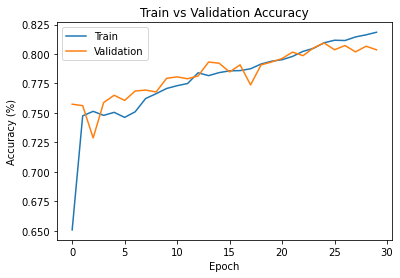

In [543]:
train_acc_1, val_acc_1 = train2()

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

The overall accuracy during the training and validation went up significantly compared to network with SGD optimizer. 

In [544]:
test_acc_1 = accuracy(test_data, batch_size=batch_size)
print("Generalization gab between test and training: ", train_acc_1[-1]-test_acc_1)

Generalization gab between test and training:  0.025274992


**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

Adam optimizer computes individual adaptive learning rate for different parameters from estimates of first and second moment of the gradient. Adam optimizer combined advantage of 2 other extensions of SGD which are Adaptive Gradient Algorithm(maintains a per-parameter learning rate that are adapted based on the average of recent magnitudes of the gradients for the weight.) and Root Mean Square Propagation(maintains per-parameter learning rate that are adapted based on the average of recent magnitides of the gradients for the weight). This is different from SGD optimizer where single learning rate for all weight update is applied along with no change in learning rate while training. 

reference: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [545]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    Embed(max_len, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [546]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [547]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [548]:
learning_rate = 1e-3
num_epochs = 30
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [549]:
# you code for the training loop should start here 

def train3(EPOCHS=num_epochs, BATCH=batch_size, LEARNING_RATE=learning_rate, MAX_PATIENCE_WINDOW=max_patience_window):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    temp_val_acc = 0
    patience_window = 0
    for epoch in range(EPOCHS):
        avg_train_loss = 0 
        avg_val_loss =  0  
        train_acc = 0      
        val_acc = 0        

        train_indices = np.arange(len(training_data[0])) 
        np.random.shuffle(train_indices)
        for it in range(0, training_data[0].shape[0], BATCH):
            batch = train_indices[it:it+BATCH]
            avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = eval_op(training_data[0][batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
        train_acc_epoch.append(train_acc/training_data[0].shape[0])
        avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

        val_indices = np.arange(len(validation_data[0])) 
        np.random.shuffle(val_indices)    
        for it in range(0, validation_data[0].shape[0], BATCH):
            batch = val_indices[it:it+BATCH]
            avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
            val_prediction = eval_op(validation_data[0][batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
        val_acc_epoch.append(val_acc/validation_data[0].shape[0])
        avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

        if val_acc_epoch[-1] > temp_val_acc:
            temp_val_acc = val_acc_epoch[-1]
            patience_window = 0
        else:
            patience_window += 1

        if patience_window == MAX_PATIENCE_WINDOW:
            print("Early Stopping at epoch# ", (epoch + 1) - patience_window)
            break

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/validation_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()
    return (train_acc_epoch, val_acc_epoch)

Epoch 0001  Training Loss 155.07 Validation Loss 126.81 Training Accuracy 64.49 Validation Accuracy 75.36
Epoch 0002  Training Loss 129.20 Validation Loss 123.31 Training Accuracy 74.85 Validation Accuracy 75.80
Epoch 0003  Training Loss 129.02 Validation Loss 126.20 Training Accuracy 74.52 Validation Accuracy 75.50
Epoch 0004  Training Loss 130.28 Validation Loss 124.79 Training Accuracy 74.27 Validation Accuracy 75.46
Epoch 0005  Training Loss 128.68 Validation Loss 125.36 Training Accuracy 74.61 Validation Accuracy 75.32
Epoch 0006  Training Loss 129.39 Validation Loss 125.01 Training Accuracy 74.36 Validation Accuracy 75.16
Early Stopping at epoch#  2


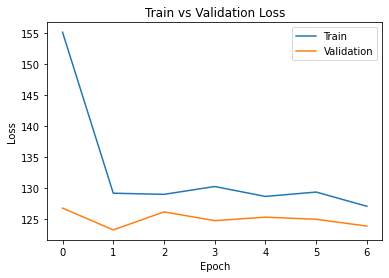

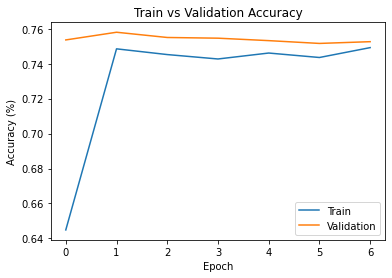

In [550]:
train_acc_3, val_acc_3 = train3()

**Question 16**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

In [551]:
print(np.max(val_acc_1), np.where(val_acc_1 == np.max(val_acc_1))[0])

0.8094 [24]


In [553]:
print(test_acc_1)

0.7932


Best model: gru_rnn2 
With 80.94% of validation accuracy at 24 epoch and test accuracy of 79.32%

